# Train a deep neural net to predict EC number 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from torchviz import make_dot
import torchvision


In [2]:
## enzyme calss labels

# Define a dictionary for the main classes
class_dict = {
    1: "Oxidoreductase",
    2: "Transferase",
    3: "Hydrolase",
    4: "Lyase",
    5: "Isomerase",
    6: "Ligase",
    7: "Translocase"
}

def map_to_class(value):
    # Split the float into integer and decimal parts
    parts = str(value).split('.')
    main_class = class_dict[int(parts[0])]
    # Join the main class with the second digit
    return main_class + " " + parts[1]



In [3]:
df = pd.read_csv("all_prepareddata_for_EzyPredict.csv")
columns_to_drop = ['UniprotID', 'EC number']
X = df.drop(columns=columns_to_drop)
y = df['EC number']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
## encode labels

# Apply the mapping function to the y_test array
y_train = [map_to_class(val) for val in y_train]
y_test = [map_to_class(val) for val in y_test]

# Combine y_train and y_test
combined_y = np.concatenate([y_train, y_test])

# Encode the combined class labels to integers
encoder = LabelEncoder()
combined_y_mapped = encoder.fit_transform(combined_y)

# Split them back
y_train_mapped = combined_y_mapped[:len(y_train)]
y_test_mapped = combined_y_mapped[len(y_train):]

# Convert them to tensors
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.int64)

In [5]:
# Convert dataframes into numpy arrays, then into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)



In [6]:
## how many classes do we have -- need to know to know how many output neurons i should have
n_classes = len(np.unique(combined_y_mapped))
print(f"Number of classes: {n_classes}")

Number of classes: 45


## Make a Neural Network

In [7]:
## Define one neural network that can take input and be used againa nd again 

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=10, output_dim = n_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
model = SimpleNN(X_train.shape[1], hidden_dim= 10, output_dim = n_classes)

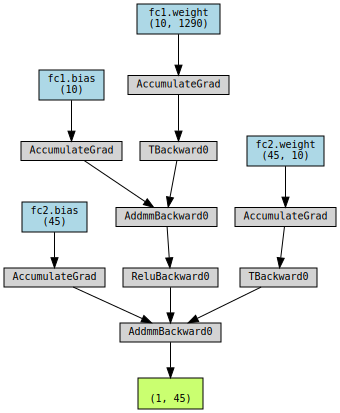

In [9]:
t = model(X_test_tensor[1].unsqueeze(0))
dot =make_dot(t, params=dict(model.named_parameters()))
display(dot)
#make_dot(t, params=dict(model.named_parameters())).render("unoptimised simpleNN", format="png")


In [10]:
criterion = nn.CrossEntropyLoss() ## google told me this was good for classifcation
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/500], Loss: 3.8146
Epoch [2/500], Loss: 3.6758
Epoch [3/500], Loss: 3.5914
Epoch [4/500], Loss: 3.5189
Epoch [5/500], Loss: 3.4720
Epoch [6/500], Loss: 3.4115
Epoch [7/500], Loss: 3.3412
Epoch [8/500], Loss: 3.2694
Epoch [9/500], Loss: 3.2194
Epoch [10/500], Loss: 3.1771
Epoch [11/500], Loss: 3.1345
Epoch [12/500], Loss: 3.0919
Epoch [13/500], Loss: 3.0514
Epoch [14/500], Loss: 3.0152
Epoch [15/500], Loss: 2.9821
Epoch [16/500], Loss: 2.9490
Epoch [17/500], Loss: 2.9156
Epoch [18/500], Loss: 2.8846
Epoch [19/500], Loss: 2.8561
Epoch [20/500], Loss: 2.8273
Epoch [21/500], Loss: 2.7962
Epoch [22/500], Loss: 2.7655
Epoch [23/500], Loss: 2.7378
Epoch [24/500], Loss: 2.7107
Epoch [25/500], Loss: 2.6809
Epoch [26/500], Loss: 2.6512
Epoch [27/500], Loss: 2.6233
Epoch [28/500], Loss: 2.5959
Epoch [29/500], Loss: 2.5675
Epoch [30/500], Loss: 2.5397
Epoch [31/500], Loss: 2.5122
Epoch [32/500], Loss: 2.4845
Epoch [33/500], Loss: 2.4579
Epoch [34/500], Loss: 2.4314
Epoch [35/500], Loss: 2

### evaluating model accuracy at total model as well as per EC class level 1 

In [11]:
model.eval() 
correct = 0
total = 0

# Create a reverse dictionary for class_dict
reverse_class_dict = {v: k for k, v in class_dict.items()}

# Dictionary to store correct and total counts for each main class
class_counts = {
    1: {"correct": 0, "total": 0},
    2: {"correct": 0, "total": 0},
    3: {"correct": 0, "total": 0},
    4: {"correct": 0, "total": 0},
    5: {"correct": 0, "total": 0},
    6: {"correct": 0, "total": 0},
    7: {"correct": 0, "total": 0},
}

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    for i in range(y_test_tensor.size(0)):
        main_class_name = y_test[i].split(' ')[0]  # Extract the main class name
        main_class = reverse_class_dict[main_class_name]  # Map the class name back to its EC number
        total += 1
        class_counts[main_class]["total"] += 1
        if predicted[i] == y_test_tensor[i]:
            correct += 1
            class_counts[main_class]["correct"] += 1

## Overall accuracy of simpleNN model with 20 hidden neurons and learning rate 0.01

In [12]:

accuracy = 100 * correct / total
print(f"Overall Test Accuracy: {accuracy:.2f}%")


Overall Test Accuracy: 59.79%


## Accuracy of each EC level 1 class of enzyme using simpleNN model with 20 hidden neurons and learning rate 0.01


In [13]:
accuracies = []
classes = []

for main_class, counts in class_counts.items():
    if counts["total"] == 0:
        class_accuracy = 0
    else:
        class_accuracy = 100 * counts["correct"] / counts["total"]
    accuracies.append(class_accuracy)
    classes.append(class_dict[main_class])

# add overall accuracy to the list
accuracies.append(accuracy)
classes.append("Overall")

# Create the dataframe
EC1_accuracies = pd.DataFrame({"Class": classes, "Accuracy": accuracies})


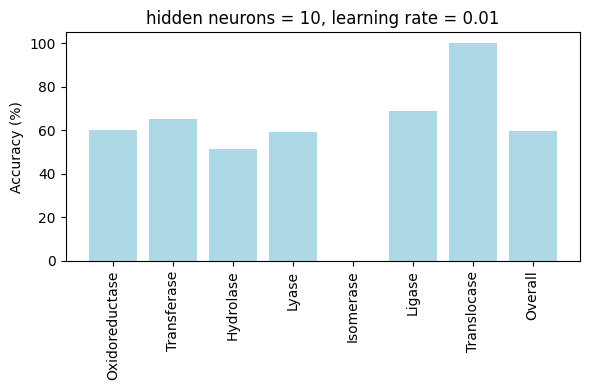

In [14]:
plt.figure(figsize=(6, 4))
plt.bar(EC1_accuracies["Class"], EC1_accuracies["Accuracy"], color="lightblue")
plt.ylabel('Accuracy (%)')
plt.title(f'hidden neurons = 10, learning rate = 0.01')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

I did expect we have a very unbalanced set of enzymes per class... will fix this later

#### will now try to optimise this model using bayesian optimisation

## Hyperparameter Tuning using bayesian optimisaton 
#### minimizing cross entropy loss between predicted EC and real EC

In [15]:
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization


def optimize_nn(lr_log, hidden_dim):
    lr = 10**lr_log
    model = SimpleNN(X_train_tensor.shape[1], int(hidden_dim), n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = 500  
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    return -loss.item()


In [16]:
pbounds = {
    'lr_log': (-12, 0),  
    'hidden_dim': (10, 200)  
## keeping hidden dimensions not too high because we have ~1200 params and only 900 inputs in the whole datase
## when I searched in more hidden_dim values, teh optimisation got stuck in higher hidden dimensions which had lower test accuracy -- overfit the data
}

In [17]:
optimizer = BayesianOptimization(
    f=optimize_nn,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=20,
    n_iter=100,
)

|   iter    |  target   | hidden... |  lr_log   |
-------------------------------------------------
| 1         | -3.248    | 81.16     | -0.5914   |
| 2         | -3.28     | 149.1     | -4.816    |
| 3         | -3.854    | 39.64     | -10.13    |
| 4         | -0.05442  | 21.04     | -1.606    |
| 5         | -0.4018   | 124.2     | -3.503    |
| 6         | -3.248    | 13.91     | -0.3611   |
| 7         | -3.811    | 168.2     | -9.452    |
| 8         | -3.812    | 44.55     | -9.799    |
| 9         | -3.788    | 67.81     | -5.703    |
| 10        | -3.832    | 92.07     | -8.505    |
| 11        | -3.825    | 126.3     | -10.33    |
| 12        | -3.775    | 65.51     | -7.604    |
| 13        | -0.0573   | 96.65     | -2.578    |
| 14        | -3.763    | 47.94     | -5.829    |
| 15        | -3.821    | 122.6     | -11.44    |
| 16        | -3.824    | 125.4     | -9.954    |
| 17        | -3.248    | 22.36     | -0.6134   |
| 18        | -0.05375  | 193.5     | -2.299    |


| 100       | -0.05382  | 168.8     | -2.434    |
| 101       | -0.7997   | 169.7     | -0.9408   |
| 102       | -2.107    | 169.5     | -4.105    |
| 103       | -0.2455   | 167.3     | -1.484    |
| 104       | -0.08233  | 166.4     | -3.207    |
| 105       | -0.05279  | 165.2     | -1.824    |
| 106       | -0.3171   | 164.4     | -3.532    |
| 107       | -0.05352  | 163.2     | -1.817    |
| 108       | -3.248    | 164.0     | -0.09072  |
| 109       | -0.1007   | 162.3     | -3.229    |
| 110       | -0.05399  | 161.1     | -1.727    |
| 111       | -0.1419   | 160.2     | -3.349    |
| 112       | -0.05297  | 159.1     | -1.695    |
| 113       | -0.07513  | 157.7     | -3.085    |
| 114       | -3.074    | 158.5     | -4.664    |
| 115       | -0.0529   | 157.0     | -1.527    |
| 116       | -0.06511  | 155.6     | -2.947    |
| 117       | -0.3351   | 154.5     | -1.326    |
| 118       | -0.1007   | 153.4     | -3.265    |
| 119       | -2.05     | 152.4     | -1.267    |


In [18]:
all_results = optimizer.res

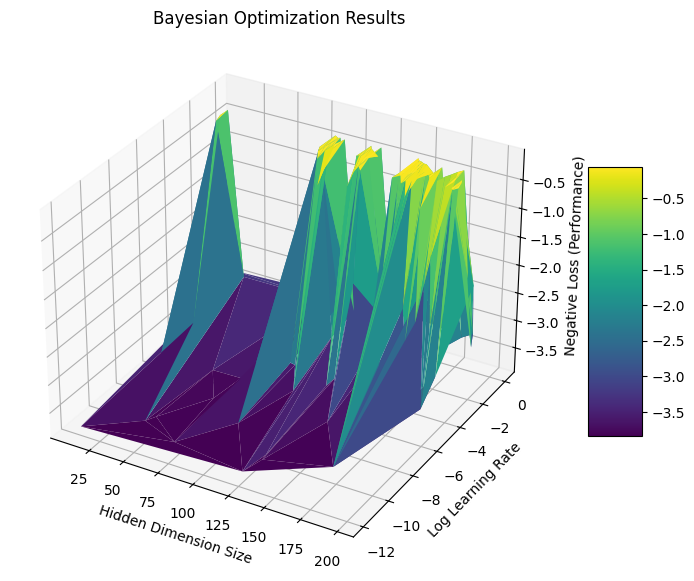

In [19]:
hidden_dims = [res['params']['hidden_dim'] for res in all_results]
lr_logs = [res['params']['lr_log'] for res in all_results]
targets = [res['target'] for res in all_results]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Creating a surface plot
surf = ax.plot_trisurf(hidden_dims, lr_logs, targets, cmap='viridis')

ax.set_xlabel('Hidden Dimension Size')
ax.set_ylabel('Log Learning Rate')
ax.set_zlabel('Negative Loss (Performance)')
ax.set_title('Bayesian Optimization Results')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


## Train model with optimized hyperparameters

In [20]:
print(optimizer.max)

{'target': -0.052546437829732895, 'params': {'hidden_dim': 175.33779026168366, 'lr_log': -1.7569372986882357}}


In [21]:
## using the optimized values of hidden_dim and learning rate from bayesian optimisation
optimal_hidden_dim = int(round(optimizer.max['params']['hidden_dim'])) 
optimal_lr = 10**optimizer.max['params']['lr_log']

model_opt = SimpleNN(X_train_tensor.shape[1], optimal_hidden_dim, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_opt.parameters(), lr=optimal_lr)


num_epochs = 500
for epoch in range(num_epochs):
    # Forward pass
    outputs = model_opt(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/500], Loss: 3.8035
Epoch [2/500], Loss: 3.6388
Epoch [3/500], Loss: 3.3413
Epoch [4/500], Loss: 3.2030
Epoch [5/500], Loss: 3.1358
Epoch [6/500], Loss: 3.0136
Epoch [7/500], Loss: 2.9119
Epoch [8/500], Loss: 2.7834
Epoch [9/500], Loss: 2.6372
Epoch [10/500], Loss: 2.5040
Epoch [11/500], Loss: 2.3792
Epoch [12/500], Loss: 2.2512
Epoch [13/500], Loss: 2.1158
Epoch [14/500], Loss: 1.9899
Epoch [15/500], Loss: 1.8591
Epoch [16/500], Loss: 1.7265
Epoch [17/500], Loss: 1.6053
Epoch [18/500], Loss: 1.4861
Epoch [19/500], Loss: 1.3703
Epoch [20/500], Loss: 1.2592
Epoch [21/500], Loss: 1.1554
Epoch [22/500], Loss: 1.0592
Epoch [23/500], Loss: 0.9654
Epoch [24/500], Loss: 0.8767
Epoch [25/500], Loss: 0.7977
Epoch [26/500], Loss: 0.7217
Epoch [27/500], Loss: 0.6523
Epoch [28/500], Loss: 0.5883
Epoch [29/500], Loss: 0.5297
Epoch [30/500], Loss: 0.4748
Epoch [31/500], Loss: 0.4238
Epoch [32/500], Loss: 0.3777
Epoch [33/500], Loss: 0.3369
Epoch [34/500], Loss: 0.2994
Epoch [35/500], Loss: 0

Epoch [281/500], Loss: 0.0535
Epoch [282/500], Loss: 0.0534
Epoch [283/500], Loss: 0.0533
Epoch [284/500], Loss: 0.0534
Epoch [285/500], Loss: 0.0535
Epoch [286/500], Loss: 0.0538
Epoch [287/500], Loss: 0.0541
Epoch [288/500], Loss: 0.0546
Epoch [289/500], Loss: 0.0551
Epoch [290/500], Loss: 0.0557
Epoch [291/500], Loss: 0.0558
Epoch [292/500], Loss: 0.0558
Epoch [293/500], Loss: 0.0553
Epoch [294/500], Loss: 0.0546
Epoch [295/500], Loss: 0.0541
Epoch [296/500], Loss: 0.0536
Epoch [297/500], Loss: 0.0534
Epoch [298/500], Loss: 0.0532
Epoch [299/500], Loss: 0.0532
Epoch [300/500], Loss: 0.0532
Epoch [301/500], Loss: 0.0532
Epoch [302/500], Loss: 0.0533
Epoch [303/500], Loss: 0.0535
Epoch [304/500], Loss: 0.0537
Epoch [305/500], Loss: 0.0540
Epoch [306/500], Loss: 0.0542
Epoch [307/500], Loss: 0.0546
Epoch [308/500], Loss: 0.0546
Epoch [309/500], Loss: 0.0546
Epoch [310/500], Loss: 0.0543
Epoch [311/500], Loss: 0.0542
Epoch [312/500], Loss: 0.0541
Epoch [313/500], Loss: 0.0541
Epoch [314

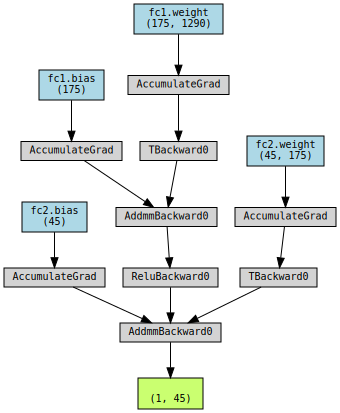

In [22]:
t = model_opt(X_test_tensor[1].unsqueeze(0))
dot =make_dot(t, params=dict(model_opt.named_parameters()))
display(dot)
#make_dot(t, params=dict(model_opt.named_parameters())).render("optimised simpleNN", format="png")


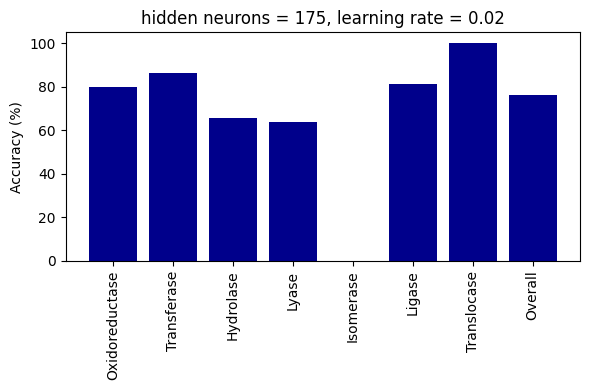

In [23]:
model_opt.eval() 
correct = 0
total = 0

# Create a reverse dictionary for class_dict
reverse_class_dict = {v: k for k, v in class_dict.items()}

# Dictionary to store correct and total counts for each main class
class_counts_optimised = {
    1: {"correct": 0, "total": 0},
    2: {"correct": 0, "total": 0},
    3: {"correct": 0, "total": 0},
    4: {"correct": 0, "total": 0},
    5: {"correct": 0, "total": 0},
    6: {"correct": 0, "total": 0},
    7: {"correct": 0, "total": 0},
}

with torch.no_grad():
    test_outputs = model_opt(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    for i in range(y_test_tensor.size(0)):
        main_class_name = y_test[i].split(' ')[0]  # EC level 1 class 
        main_class = reverse_class_dict[main_class_name]  
        total += 1
        class_counts_optimised[main_class]["total"] += 1
        if predicted[i] == y_test_tensor[i]:
            correct += 1
            class_counts_optimised[main_class]["correct"] += 1
            
accuracies = []
classes = []

for main_class, counts in class_counts_optimised.items():
    if counts["total"] == 0:
        class_accuracy = 0
    else:
        class_accuracy = 100 * counts["correct"] / counts["total"]
    accuracies.append(class_accuracy)
    classes.append(class_dict[main_class])

overall_accuracy = 100 * correct / total
# add overall accuracy to the list
accuracies.append(overall_accuracy)
classes.append("Overall")
# Create the dataframe
EC1_accuracies = pd.DataFrame({"Class": classes, "Accuracy": accuracies})

plt.figure(figsize=(6, 4))
plt.bar(EC1_accuracies["Class"], EC1_accuracies["Accuracy"], color="darkblue")
plt.ylabel('Accuracy (%)')
plt.title(f'hidden neurons = {optimal_hidden_dim}, learning rate = {optimal_lr:.2f}')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")


Overall Test Accuracy: 76.19%


##  improved the accuracy a little bit ! 